In [1]:
# Predict dog breed from image

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
print("GPU is", "available" if torch.cuda.is_available() else "NOT AVAILABLE")
print(torch.__version__)

GPU is available
1.5.1


In [3]:
# import images dataset
import os
from PIL import Image
#import cv2


BATCH_SIZE = 32
IMG_SIZE = (512, 512)

#dataset_description_path = "C:\Users\Drake Li\Desktop\cwd\ds-stuff\data\list.txt"
dataset_path = "./data/cat-dog-images"
labels_path = "./cat-breed-classes.json"
model_path = "./cat_breed_vgg16.pth"    #save to here
#Image CLASS-ID SPECIES BREED ID
#ID: 1:37 Class ids
#SPECIES: 1:Cat 2:Dog
#BREED ID: 1-25:Cat 1:12:Dog
#All images with 1st letter as captial are cat images
#images with small first letter are dog images

# load dataset

In [4]:
import random
dataset=[]

classes = {}
labelcounter=0
    
for i,fn in enumerate(os.listdir(dataset_path)):
    if(fn.endswith(".mat")):#skip those
        continue
    if(fn[0].isupper() == False):
        pass
    else:
        
        breed_name =fn[:fn.rfind("_")]#from rule
        
        
        #labels.append(breed_name)
        img_bytes = Image.open(os.path.join(dataset_path,fn))
        img = torchvision.transforms.functional.resize(img=img_bytes,size=IMG_SIZE)#resize img
        img=(np.array(img)/255.0).astype(np.float32)
        #should be [300,300,3]
        if(img.shape != (IMG_SIZE[0],IMG_SIZE[1],3)):
            #skip some black-white image or non-standard rgb image
            continue
            
        c = breed_name
        #print(c)
        if(c not in classes):
            #new breed label
            classes[c]=labelcounter
            labelcounter+=1
        dataset.append([img,classes[c]])


        
    
print(classes)


print("dataset size:{}".format(len(dataset)))     #3670
train_size=int(len(dataset)*0.8)
test_size=len(dataset)-train_size

#remember to shuffle
random.shuffle(dataset)
#doesn't hurt to shuffle again
trainloader = torch.utils.data.DataLoader(dataset[:train_size], shuffle=True, batch_size=BATCH_SIZE)
testloader = torch.utils.data.DataLoader(dataset[train_size:], shuffle=True, batch_size=BATCH_SIZE)
print("loaded data.")


{'Abyssinian': 0, 'Bengal': 1, 'Birman': 2, 'Bombay': 3, 'British_Shorthair': 4, 'Egyptian_Mau': 5, 'Maine_Coon': 6, 'Persian': 7, 'Ragdoll': 8, 'Russian_Blue': 9, 'Siamese': 10, 'Sphynx': 11}
dataset size:2390
loaded data.


In [5]:
#save labels here
# import json
# with open(labels_path,"w") as fp1:
#     json.dump(classes,fp1)
# print("Labels saved to files.")

rows=5,cols=5


<Figure size 1500x1500 with 0 Axes>

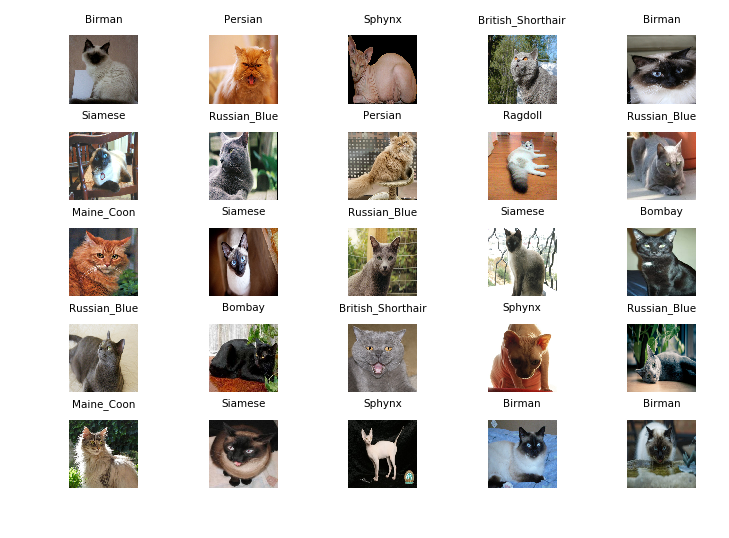

In [6]:
# plot some of the images
import matplotlib.pyplot as plt
import random
import math
import utils
import json
random.seed(233)

    
with open(labels_path,"r") as fp1:
    classes = json.load(fp1)
    classes = {k:int(v) for k,v in classes.items()}
    classes_rev = {int(v):k for k,v in classes.items()}
        

plt.rcParams['figure.dpi'] = 150




subset = random.sample(dataset,25)
utils.show_imgs(data=[item[0] for item in subset],real_labels=[item[1] for item in subset],classes_rev=classes_rev)



In [7]:
import torchvision.models as models
from torchsummary import summary
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.parameters():
    #print(param)
    param.requires_grad = False

vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=len(classes))
# vgg16.classifier. torch.nn.Softmax
print(vgg16)

#vgg16.cuda()    #move it to cuda
#summary(vgg16, (3, 300, 300))


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
#take a look of example input-output of mdel
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    # torch.max[0] stores the data, torch.max[1] stores the index (of the max)
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

for images, labels in trainloader:
    b = images.permute(0,3,1,2)#rearrange shape
    print(b.shape)
    
    out = vgg16(b)
    print("batch size:", images.shape)
    print(out.shape)
    acc = get_accuracy(out,labels,BATCH_SIZE)
    
    #out[i] is array[5] with probability; labels[i] is ground truth
    #use max of out[i] as prediction
    print("{},{}".format(out[0],labels[0]))
    break
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False
    return
# for images, labels in trainloader:
#     pass
for images, labels in testloader:
    pass
print("ok")

torch.Size([32, 3, 512, 512])
batch size: torch.Size([32, 512, 512, 3])
torch.Size([32, 12])
tensor([ 0.0269, -0.1259, -0.1942,  0.0968,  0.1169, -0.1665, -0.3660, -0.3690,
         0.1244,  0.2081, -0.3633,  0.0757], grad_fn=<SelectBackward>),8
ok


In [15]:
#start training
import torch.optim as optim

learning_rate = 0.01
num_epochs=20

criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(vgg16.classifier[-1].parameters(),lr=learning_rate,momentum=0.9)

torch.cuda.empty_cache()

In [10]:
res=[]
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
vgg16.to(device)
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0
    vgg16 = vgg16.train()
    for i, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        b = images.permute(0,3,1,2)
        out = vgg16(b)
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        del b
        del images
        ## update model params
        optimizer.step()
        train_running_loss += loss.detach().item()      #make a copy without tracking it
        train_acc += get_accuracy(out, labels, BATCH_SIZE)#use += instead of =
        del labels
        del loss
    vgg16.eval()
    test_acc = 0.0
    if(True):
        for j, (images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            b = images.permute(0,3,1,2)
            outputs = vgg16(b)
            test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
            del images
            del labels
            del b

        print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f | Test Accuracy: %.2f' \
              %(epoch, train_running_loss / i, train_acc/i, test_acc/j ))#accumulated, so use += before
        res.append([learning_rate, epoch, train_running_loss / i, train_acc/i, test_acc/j])

freeze_model(vgg16)#freeze the model

cuda:0
Epoch: 0 | Loss: 1.4848 | Train Accuracy: 50.48 | Test Accuracy: 65.62
Epoch: 1 | Loss: 0.9567 | Train Accuracy: 67.96 | Test Accuracy: 76.56
Epoch: 2 | Loss: 0.8923 | Train Accuracy: 69.81 | Test Accuracy: 71.65
Epoch: 3 | Loss: 0.7922 | Train Accuracy: 72.78 | Test Accuracy: 81.03
Epoch: 4 | Loss: 0.7757 | Train Accuracy: 73.25 | Test Accuracy: 73.66
Epoch: 5 | Loss: 0.7448 | Train Accuracy: 75.53 | Test Accuracy: 75.67
Epoch: 6 | Loss: 0.7784 | Train Accuracy: 74.79 | Test Accuracy: 80.58
Epoch: 7 | Loss: 0.7614 | Train Accuracy: 75.16 | Test Accuracy: 80.80
Epoch: 8 | Loss: 0.6886 | Train Accuracy: 77.01 | Test Accuracy: 76.56
Epoch: 9 | Loss: 0.6657 | Train Accuracy: 77.81 | Test Accuracy: 79.46
Epoch: 10 | Loss: 0.6915 | Train Accuracy: 76.85 | Test Accuracy: 76.56
Epoch: 11 | Loss: 0.7174 | Train Accuracy: 75.85 | Test Accuracy: 80.36
Epoch: 12 | Loss: 0.6648 | Train Accuracy: 77.75 | Test Accuracy: 82.59
Epoch: 13 | Loss: 0.7278 | Train Accuracy: 76.59 | Test Accuracy: 7

model saved to ./cat_breed_vgg16.pth
torch.Size([25, 3, 512, 512])
[ 7  8  4 11  1  6  9 10  5  2 11 11  0  7  1  7  5 10  5  9 11  8  2  5
  0]
correct prediction:21/25
rows=5,cols=5


<Figure size 1500x1500 with 0 Axes>

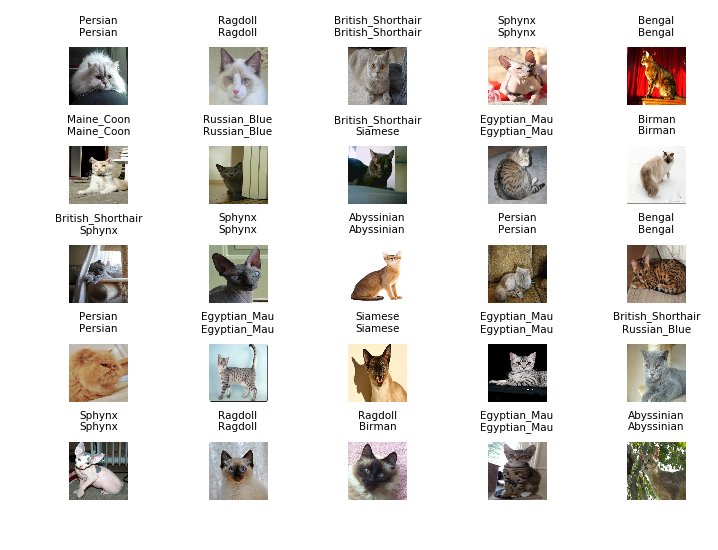

In [11]:
#evaluate in a visualized way

torch.save(vgg16, model_path)
print("model saved to {}".format(model_path))
subset = random.sample(dataset,25)
imgs = np.asarray([item[0] for item in subset])
    #subset=np.append(subset,item[0])
imgs = torch.tensor(imgs)
imgs = imgs.to(device)
b = imgs.permute(0,3,1,2)

print(b.shape)
outputs = vgg16(b)
outputs = torch.max(outputs, 1)[1].data.cpu().numpy() #convert into array
print(outputs)
correct_num=0
for i in range(25):
    if(outputs[i] == subset[i][1]):
        correct_num+=1
print("correct prediction:{}/25".format(correct_num))
utils.show_imgs(data=[item[0] for item in subset],real_labels=[item[1] for item in subset],pred_labels=outputs,classes_rev=classes_rev)

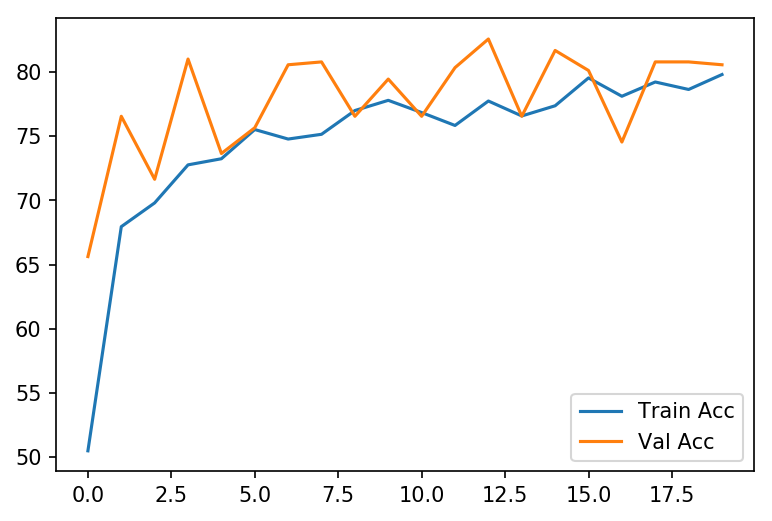

In [12]:
import pandas as pd
df = pd.DataFrame(res, columns = ["Learning Rate", "Epoch", "Train Loss", "Train Acc", "Val Acc"])
df[["Train Acc", "Val Acc"]].plot()

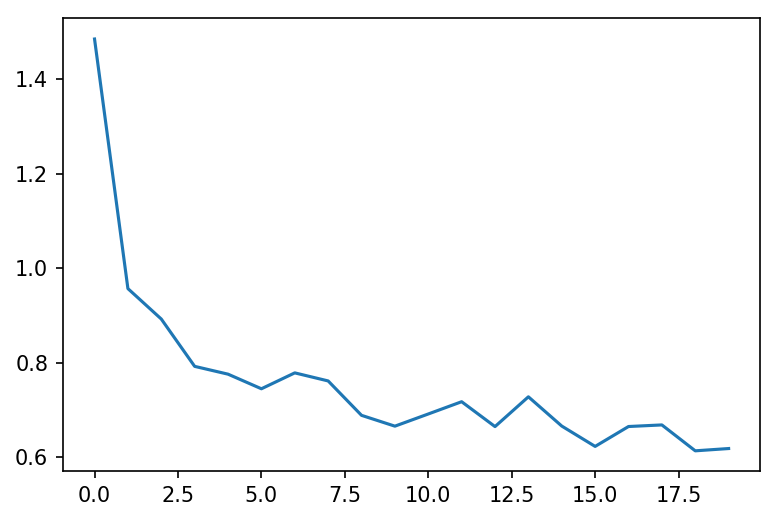

In [13]:
df["Train Loss"].plot()

{0: 'Abyssinian', 1: 'Bengal', 2: 'Birman', 3: 'Bombay', 4: 'British_Shorthair', 5: 'Egyptian_Mau', 6: 'Maine_Coon', 7: 'Persian', 8: 'Ragdoll', 9: 'Russian_Blue', 10: 'Siamese', 11: 'Sphynx'}
torch.Size([5, 3, 300, 300])
[ 0  6 10  0 11]
rows=2,cols=3


<Figure size 1500x1500 with 0 Axes>

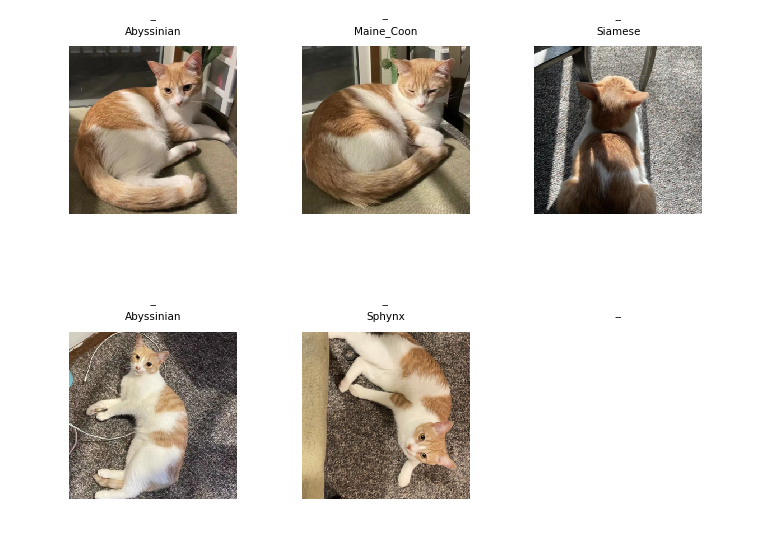

In [20]:
#same as use_models.ipynb
import torch
from PIL import Image
import torchvision
import numpy as np
import utils
import json
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
IMG_SIZE=(300,300)
vgg16 = torch.load(model_path, map_location=torch.device(device))
with open("./cat-breed-classes.json","r") as fp1:
    classes = json.load(fp1)
    classes = {k:int(v) for k,v in classes.items()}
    classes_rev = {int(v):k for k,v in classes.items()}
print(classes_rev)
def recognize_img(img_paths):
    imgs=[]
    for img_path in img_paths:
        img_bytes = Image.open(img_path)
        img = torchvision.transforms.functional.resize(img=img_bytes,size=IMG_SIZE)#resize img
        img=(np.array(img)/255.0).astype(np.float32)
        imgs.append(img)
    imgs = np.asarray(imgs)
    #subset=np.append(subset,item[0])
    imgs_tensor = torch.tensor(imgs)
    imgs_tensor = imgs_tensor.to(device)
    b = imgs_tensor.permute(0,3,1,2)

    print(b.shape)
    outputs = vgg16(b)
    outputs = torch.max(outputs, 1)[1].data.cpu().numpy() #convert into array
    print(outputs)
    
    utils.show_imgs(imgs,real_labels=None,pred_labels=outputs,classes_rev=classes_rev)
    
img_paths = [
             r"C:\Users\Drake Li\Desktop\cwd\ds-stuff\data\etc_imgs\pp2_cr.jpg",
             r"C:\Users\Drake Li\Desktop\cwd\ds-stuff\data\etc_imgs\pp3_cr.jpg",
             r"C:\Users\Drake Li\Desktop\cwd\ds-stuff\data\etc_imgs\pp4_cr.jpg",
             r"C:\Users\Drake Li\Desktop\cwd\ds-stuff\data\etc_imgs\pp5_cr.jpg",
             r"C:\Users\Drake Li\Desktop\cwd\ds-stuff\data\etc_imgs\pp6_cr.jpg",
            ]
recognize_img(img_paths)